#Ensemble Kalman filter
The code is not yet completed, it has some overflow issue

In [1]:
# import all the required packages
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [2]:
## functions defined
# process equation:
def f(x,u):
    dt = 0.01
   
    m = 1
    k = 100
    c = 0.4
    A = np.array([[0, 1],[-k/m,-c/m]])
    B = np.array([[0],[1/m]])
    Ad = expm(A*dt)
    Bd = np.linalg.inv(A)@(Ad-np.eye(2))@B
    x = Ad@x+Bd*u
    return x

# measurement equation:
def g(x,u):
    m = 1
    k = 100
    c = 0.4
    C = np.array([-k/m,-c/m])
    D = np.array([1/m])
    y = C@x + D*u   

    return y

# # runga-kutta combined 4th and 5th order solver
# def rk45(x,u,dt,tol):
#     x1 = rk4(x,u,dt)
#     x2 = rk5(x,u,dt)
#     itr = 1
#     h = dt

#     while abs(x1-x2).all() > tol/itr:
#         itr = itr + 1
#         h = dt/itr
#         x1 = rk4(x,u,h)
#         x2 = rk5(x,u,h)
    
#     for i in range(itr):
#         x = rk5(x,u,h)

#     return x 

# # runga-kutta 4th order solver
# def rk4(x,u,dt):
#     k1 = ss_model(x,u)
#     k2 = ss_model(x+dt/2*k1,u)
#     k3 = ss_model(x+dt/2*k2,u)
#     k4 = ss_model(x+dt*k3,u)
#     x = x + dt/6*(k1+2*k2+2*k3+k4)
#     return x

# # runga-kutta 5th order solver
# def rk5(x,u,dt):
#     k1 = ss_model(x,u)
#     k2 = ss_model(x+dt/4*k1,u)    
#     k3 = ss_model(x+dt/8*k1+dt/8*k2,u) 
#     k4 = ss_model(x-dt/2*k2+dt*k3,u)
#     k5 = ss_model(x+3/16*dt*k1+9/16*dt*k4,u)
#     k6 = ss_model(x-3/7*dt*k1+2/7*dt*k2+12/7*dt*k3-12/7*dt*k4+8/7*dt*k5,u)
#     x = x + dt/90*(7*k1+32*k3+12*k4+32*k5+7*k6)

#     return x

# # state-space model
# def ss_model(x,u):
#     m = 1
#     k = 100
#     c = 0.4
#     duffing_k = 10
#     x_derivative = np.array([[x[1][0]],[-k/m*x[0][0]-c/m*x[1][0]-duffing_k*x[0][0]**3/m+u/m]])

#     return x_derivative

In [3]:
# measurement data generation
u_store = np.load('u_data.npy')
x_true = np.zeros((2,1001))
y_true = np.zeros((1000,1))
x = np.array([[0.0],[0.0]])
for i in range(1000):
    # u = np.random.randn()
    u = u_store[0,i]
    # u = 0
    x = f(x,u)
    y = g(x,u)

    x_true[:,i] = x[:,0] 
    y_true[i] = y[0]
    # print(x[:,0])
y_meas = y_true

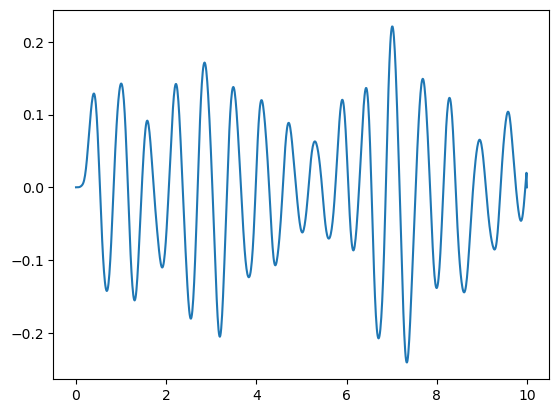

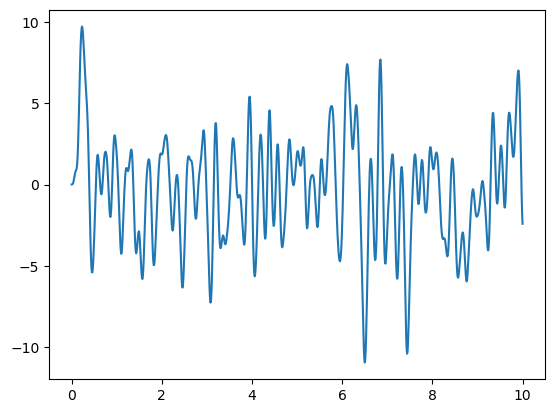

In [4]:
t = np.linspace(0,10,1001)
plt.figure(1)
plt.plot(t,x_true[0,:])

plt.figure(2)
plt.plot(t,u_store.T)

In [9]:
T = 10 # 10 seconds
freq = 100 # sampling frequency
dt = 1/freq
t = np.linspace(0,10,1001,endpoint=True)

n = 2 # size of state x
m = 1 # size of measurement y
q = 10 # number of samples in EnKF

Q = np.diag([0.001,0.001])
R = np.diag([0.0001])
Q_chol = np.linalg.cholesky(Q)
R_chol = np.linalg.cholesky(R)

x_store = np.zeros((n,1001))
y_store = np.zeros((m,1001))
x_sigma_store = np.zeros((n,1001))
y_sigma_store = np.zeros((m,1001))
x_samples = np.zeros((n,q))
y_samples = np.zeros((m,q))

# initialize
x = np.array([[0.0],[0.]])
x_samples = x + Q_chol@np.random.randn(n,q)

x_store[:,0] = x[:,0]
x_sigma_store[:,0] = np.diag(Q_chol)
for i in range(1000):
    u = u_store[0,i]
    y_meas = y_store[:,i]

    # prediction/forecast step
    for j in range(q):
        x_samples[:,j] = f(np.reshape(x_samples[:,j],(n,1)),u)[:,0]

    x_mean = np.reshape(np.mean(x_samples,1),(n,1))

    E_xx = x_samples - x_mean   

    # P_xx = 1/(q-1)*E_xx@E_xx.T # here there is no need to predict covarinace P

    # update/analysis step
    for j in range(q):
        y_samples[:,j] = g(np.reshape(x_samples[:,j],(n,1)),u)
    y_meas_samples = y_meas + R_chol@np.random.randn(m,q)
    y_meas_mean = np.mean(y_meas_samples) #y_meas

    E_yy = y_meas_samples - y_meas_mean
    P_yy = 1/(q-1)*E_yy@E_yy.T
    P_xy = 1/(q-1)*E_xx@E_yy.T

    K = P_xy@np.linalg.inv(P_yy)

    x_samples = x_samples + K@(y_meas_samples-y_samples)
    x_mean = np.reshape(np.mean(x_samples,1),(n,1))

    E_xx = x_samples - x_mean
    P_xx = 1/(q-1)*E_xx@E_xx.T

    # store the result
    x_store[:,i+1] = x_mean[:,0]
    x_sigma_store[:,i+1] = np.diag(P_xx)**0.5
    # print(i)
    

[[0.02230793 0.01890173]
 [0.027169   0.0237628 ]]
[0.02230793 0.0237628 ]


[[ 0.99582756 -1.88318608]
 [ 0.68904281 -2.18997084]]
[ 0.99582756 -2.18997084]
[[ 1251.19484127 -3591.15249508]
 [  726.84079736 -4115.506539  ]]
[ 1251.19484127 -4115.506539  ]
[[ 1.50068928e+10 -5.84260893e+10]
 [ 7.05512654e+09 -6.63778556e+10]]
[ 1.50068928e+10 -6.63778556e+10]
[[-7.10159809e+23  3.55568749e+24]
 [-2.48228128e+23  4.01761918e+24]]
[-7.10159809e+23  4.01761918e+24]
[[ 5.48618344e+51 -3.42859072e+52]
 [ 1.17942153e+51 -3.85926691e+52]]
[ 5.48618344e+51 -3.85926691e+52]
[[ 2.34448251e+107 -1.79941066e+108]
 [ 1.42097382e+106 -2.01964918e+108]]
[ 2.34448251e+107 -2.01964918e+108]
[[ 3.86129698e+218 -3.61555753e+219]
 [-4.71971367e+217 -4.04888437e+219]]
[ 3.86129698e+218 -4.04888437e+219]
[[nan nan]
 [nan nan]]
[ nan -inf]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan 

C:\Users\smicr\AppData\Local\Temp\ipykernel_28232\4108000486.py:55: RuntimeWarning: overflow encountered in matmul
  x_samples = x_samples + K@(y_meas_samples-y_samples)
c:\Users\smicr\anaconda3\Lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\smicr\AppData\Local\Temp\ipykernel_28232\3932737813.py:13: RuntimeWarning: invalid value encountered in matmul
  x = Ad@x+Bd*u


[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]
 [nan nan]]
[nan nan]
[[nan nan]

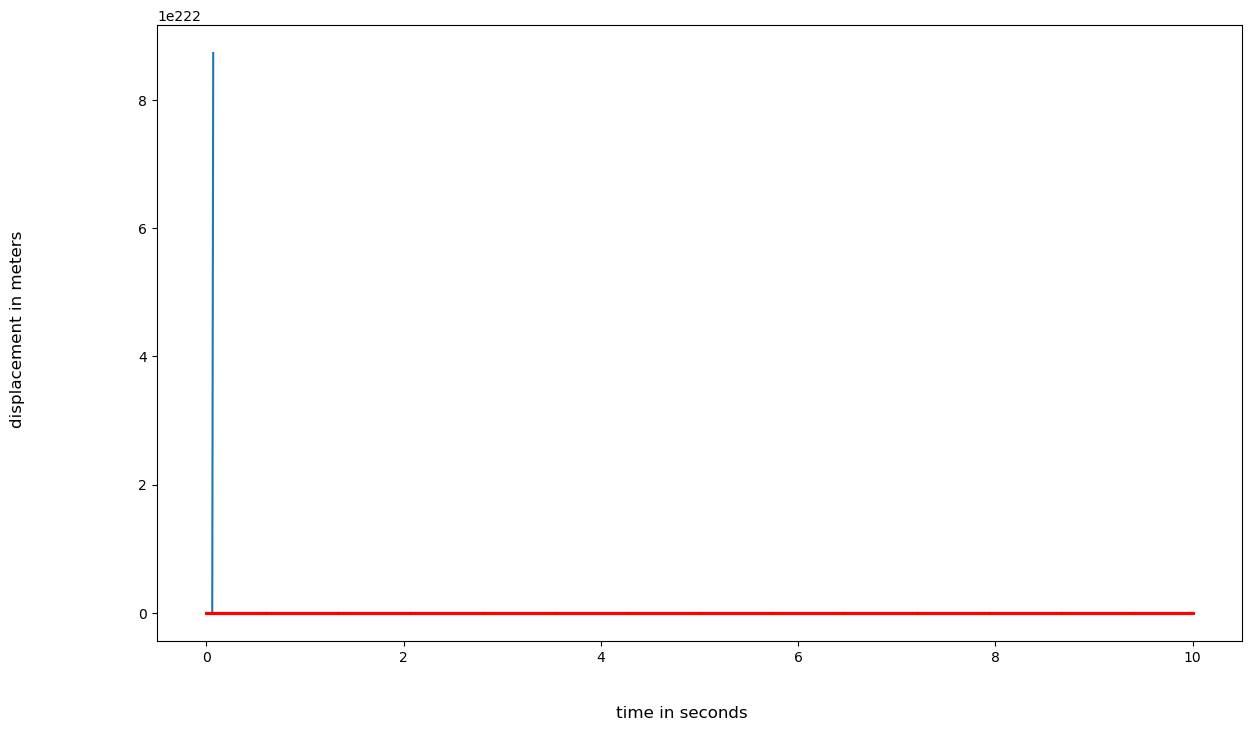

In [6]:
# plots
m = 1 # no of plots
fig = plt.figure(figsize=(14,8), dpi=100)
for j in range(m):
    plt.fill_between(t, x_store[0,:]-1.96*x_sigma_store[0,:], x_store[0,:]+1.96*x_sigma_store[0,:], alpha=0.3)
    plt.plot(t,x_store[0,:])
    plt.plot(t,x_true[0,:],'r*',markersize=2)
fig.supxlabel('time in seconds')
fig.supylabel('displacement in meters')
plt.show()
